## WEEK4. Coding homework_round2(18-05-29, 정누리)
### part1

- datetime - hourly date + timestamp  
- season: 1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

 

이번 노트북에 들어가야하는 내용은 아래와 같습니다.

 

0. 데이터셋에 대한 간단한 EDA

1. 분류 문제로 풀어보기 (수요 낮음, 중간, 높음 - 나누는 기준은 자신만의 논리로 정하기) 
    - 모델 피팅은 train (70%) / test (30%)로 나누고, 5-cv를 돌릴 것
    - Logistic regression
    - LDA
    - Naive Bayes
    - Random Forest
    - Gradient Boosted Tree


2. 1의 모델 피팅 결과에 대한 정확도를 하나의 테이블 또는 Figure 일목요연하게 보여주기

3. 위의 문제를 다시 regression 문제로 풀어보기 (카운트 데이터라는 것 감안할 것)

In [178]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 0. 데이터 셋에 대한 간단한 EDA

In [179]:
train = pd.read_csv("train (1).csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [180]:
train.shape

(10886, 12)

In [181]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


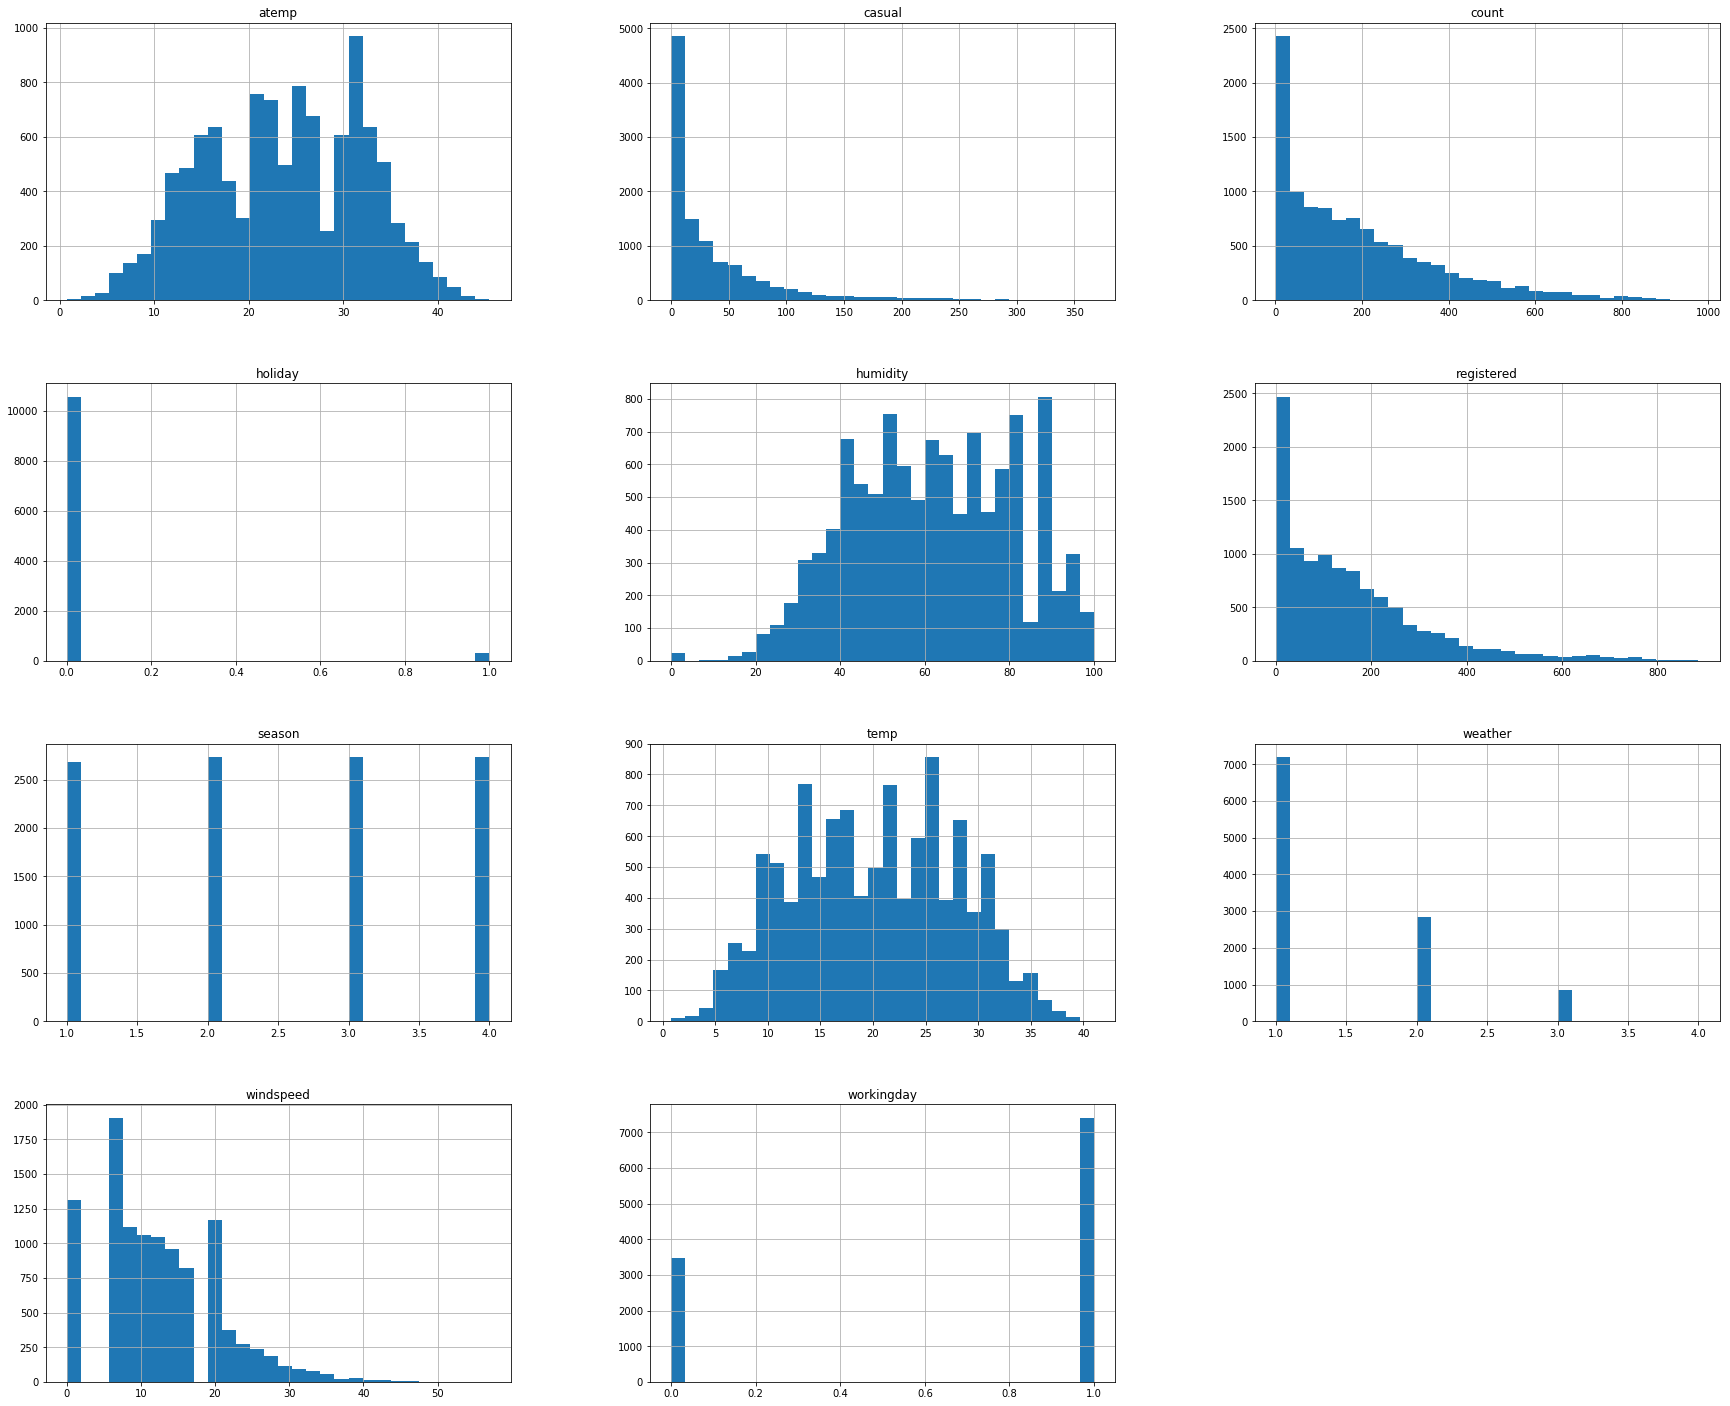

In [182]:
train.hist(bins = 30, figsize = (30,25))
plt.show()

- atemp와 temp 변수
    - 두 변수의 히스토그램은 비슷하면서도 다름. 날짜별로 볼 필요 있음. 
    - humidity + weather 가 atemp, temp에 영향을 미칠지도? 
    - temp - atemp(실제 온도와 체감온도 차)라는 변수도 만들어 볼 수 있을까?
- registered 와 casual
    - registered 이용자가 casual 이용자보다 더 많음
    - casual + registered = count 인가? 그러면 나중에 새로운 데이터셋 들어왔을 때 casual, registered는 예측해야 할 y 변수인데 어떻게 x로 파악 가능?  
- workingday 와 holiday (명목)
    - holiday는 몇 일 없음 주말이랑 다른 개념인듯? 
    - working day = weekend & holiday 아닌날
    - 그럼 weekend 변수도 뽑을 수 있음? 예: holiday == 0 & workingday == 0 이면 weekend? 
    - 아니면 요일 변수 만들어서 주말 분류. 
- season (명목)
    - 계절별 데이터 골고루 분포. 기간이 꽉 채운 n년인건가? 날짜 쪼개서 보기
- weather (명목)
    - 보통은 날씨 좋음
- windspread
    - 보통은 바람 별로 불지 않음

### 종속변수 y 살펴보기
- 대여량이 0인 때가 매우 많음 --> log 취한 "ln_count" 변수 만들기 --> 어차피 분류문제로 풀 거라 상관이 없을까...??????

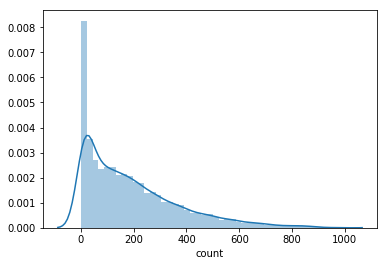

In [183]:
sns.distplot(train["count"])

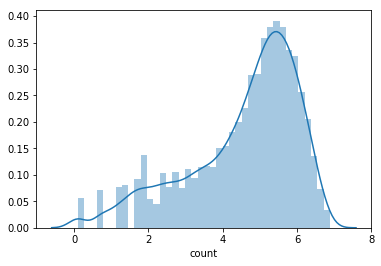

In [184]:
sns.distplot(np.log(train["count"]+0.1))

In [185]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [186]:
train["ln_count"] = np.log(train["count"]+0.1) #ln_count 변수 생성함

### 독립변수와 종속변수의 관계 살펴보기

In [187]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'ln_count'],
      dtype='object')

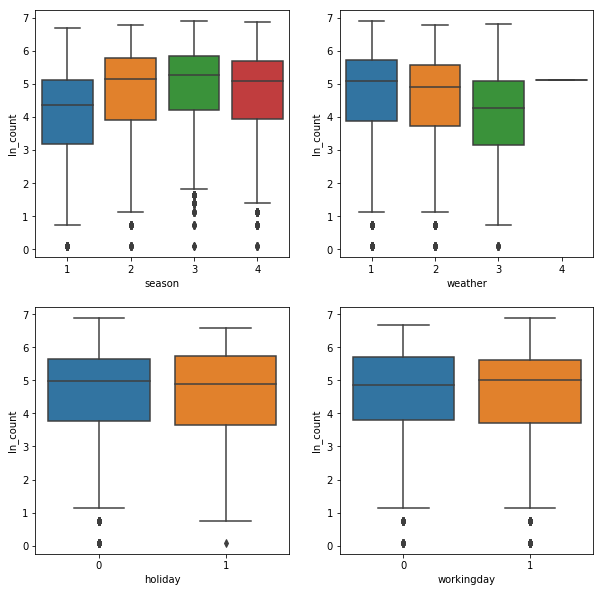

In [188]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(10, 10)

sns.boxplot(data=train, x="season", y="ln_count", ax=ax1)
sns.boxplot(data=train, x="weather", y="ln_count", ax=ax2)
sns.boxplot(data=train, x="holiday", y="ln_count", ax=ax3)
sns.boxplot(data=train, x="workingday", y="ln_count", ax=ax4)

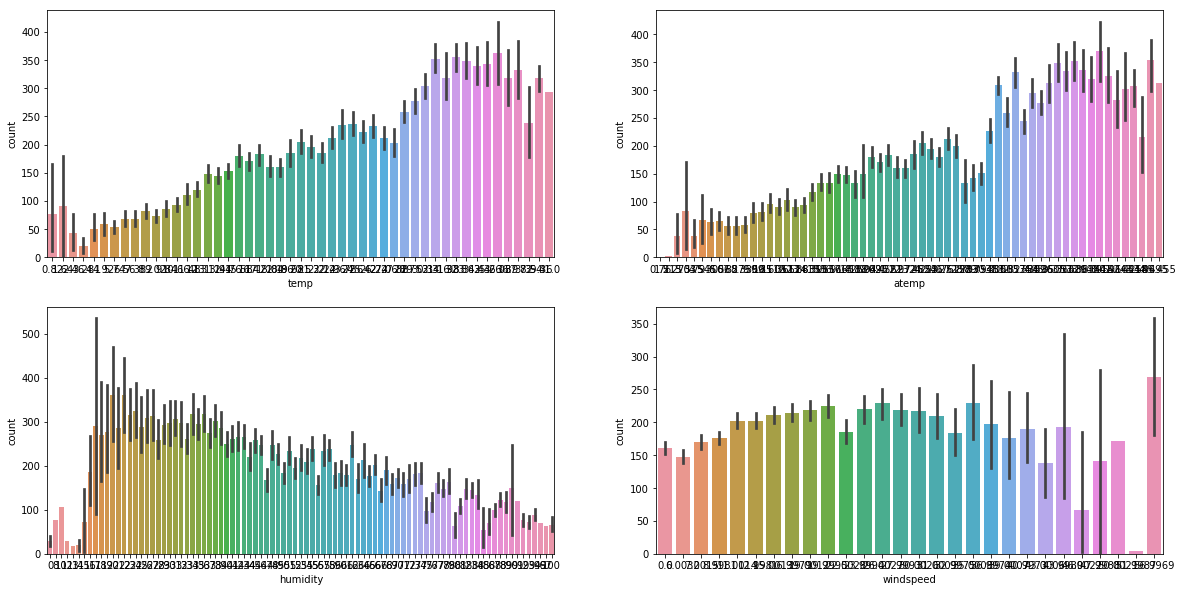

In [189]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20, 10)

sns.barplot(data=train, x="temp", y="count", ax=ax1)
sns.barplot(data=train, x="atemp", y="count", ax=ax2)
sns.barplot(data=train, x="humidity", y="count", ax=ax3)
sns.barplot(data=train, x="windspeed", y="count", ax=ax4)

### >>> Thoughts 
- 온도가 적당히 높고, 습도가 낮을수록 대여량은 높아질 것 (interaction)

In [190]:
train['humidity_n_temp'] = np.log(train['humidity']+.1)*train['temp']

In [191]:
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,ln_count,humidity_n_temp
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,0.161002,0.300857
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,-0.000538,0.006236
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.017792,0.024299
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.106314,0.012750
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.374220,0.961607
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.369880,0.952209
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.328692,0.168526
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,0.120654,-0.084122
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.569819,0.370164
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.780068,0.252807


In [192]:
#figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
#figure.set_size_inches(20, 10)

#sns.pointplot(data=train, x="temp", y="ln_count", ax=ax1)
#sns.pointplot(data=train, x="atemp", y="ln_count", ax=ax2)
#sns.pointplot(data=train, x="humidity", y="ln_count", ax=ax3)
#sns.pointplot(data=train, x="windspeed", y="ln_count", ax=ax4)

### 날짜 데이터 쪼개기
sns.pointplot(data=train, x="datetime", y="count") 
시도해봤으나, 너무 오래 걸림. 날짜를 쪼개서 봐야할 것 같음

In [193]:
train["datetime_year"] = train["datetime"].dt.year
train["datetime_month"] = train["datetime"].dt.month
train["datetime_day"] = train["datetime"].dt.day
train["datetime_hour"] = train["datetime"].dt.hour
train["datetime_minute"] = train["datetime"].dt.minute

In [194]:
train.shape

(10886, 19)

In [195]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,ln_count,humidity_n_temp,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_minute
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2.778819,43.253520,2011,1,1,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,3.691376,39.537148,2011,1,1,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,3.468856,39.537148,2011,1,1,2,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2.572612,42.497194,2011,1,1,3,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,0.095310,42.497194,2011,1,1,4,0
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,0.095310,42.497194,2011,1,1,5,0
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,0.741937,39.537148,2011,1,1,6,0
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,1.131402,36.535177,2011,1,1,7,0
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2.091864,42.497194,2011,1,1,8,0
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,2.646175,56.836473,2011,1,1,9,0


In [196]:
train["datetime_minute_ratio"] = train["datetime_minute"]/60

In [197]:
train[train["datetime_minute"] == 0].count

<bound method DataFrame.count of                  datetime  season  holiday  workingday  weather   temp  \
0     2011-01-01 00:00:00       1        0           0        1   9.84   
1     2011-01-01 01:00:00       1        0           0        1   9.02   
2     2011-01-01 02:00:00       1        0           0        1   9.02   
3     2011-01-01 03:00:00       1        0           0        1   9.84   
4     2011-01-01 04:00:00       1        0           0        1   9.84   
5     2011-01-01 05:00:00       1        0           0        2   9.84   
6     2011-01-01 06:00:00       1        0           0        1   9.02   
7     2011-01-01 07:00:00       1        0           0        1   8.20   
8     2011-01-01 08:00:00       1        0           0        1   9.84   
9     2011-01-01 09:00:00       1        0           0        1  13.12   
10    2011-01-01 10:00:00       1        0           0        1  15.58   
11    2011-01-01 11:00:00       1        0           0        1  14.76   
12   

### >>>Thoughts
- 분단위는 60으로 나눠서 좀 더 자세하게 반영하려고 했는데, 애초에 분단위 데이터가 없음. 분단위 데이터는 전부 0임. 
- 시간까지만 변수 생성하면 되기 때문에 분단위 변수 삭제

In [198]:
del train["datetime_minute_ratio"]

In [199]:
del train["datetime_minute"]

In [200]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,ln_count,humidity_n_temp,datetime_year,datetime_month,datetime_day,datetime_hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2.778819,43.253520,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,3.691376,39.537148,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,3.468856,39.537148,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2.572612,42.497194,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0.095310,42.497194,2011,1,1,4


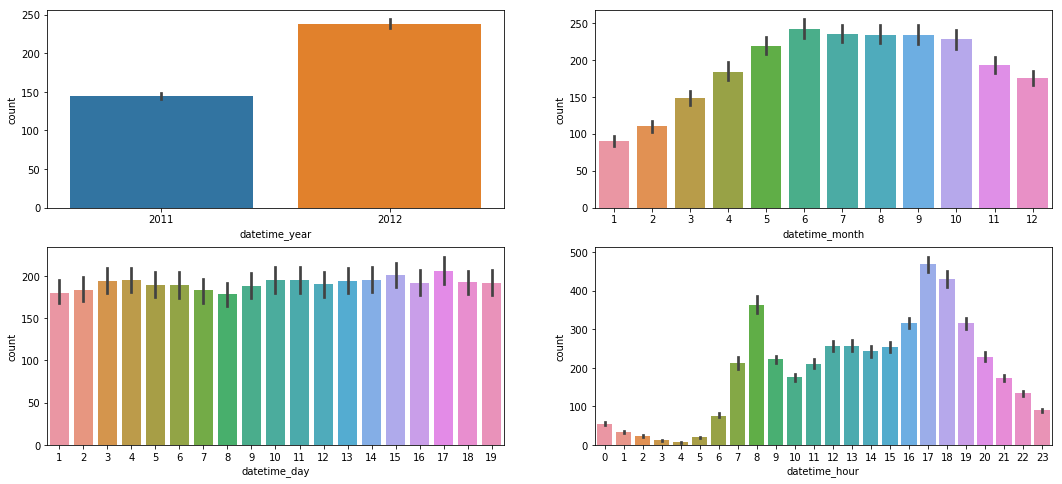

In [201]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18, 8)

sns.barplot(data=train, x="datetime_year", y="count", ax=ax1)
sns.barplot(data=train, x="datetime_month", y="count", ax=ax2)
sns.barplot(data=train, x="datetime_day", y="count", ax=ax3)
sns.barplot(data=train, x="datetime_hour", y="count", ax=ax4)

In [202]:
train[train["datetime_day"] > 19]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,ln_count,humidity_n_temp,datetime_year,datetime_month,datetime_day,datetime_hour


### >>> Thoughts
- year : 전년 대비 이용량 증가
- month: 겨울보다 여름에 이용량 많음
- day 변수는 19일까지 밖에 자료가 없고, 변동성이 크지 않아 예측 변수에서 제외하는 것이 타당해보임
- hour: 8시, 17시 경에 이용량이 많은데 아마 출퇴근 시간에 이용하는 것으로 예상 --> 이는 holiday, weekday, weekend에 따라 다르게 나타날 것
- 요일별 이용량 살펴보기

In [203]:
def func_year(x):
    if x == 2011 :
        return 0
    else:
        return 1
train['datetime_year'] = train['datetime_year'].apply(func_year)

In [204]:
train['datetime_year'].head()

0    0
1    0
2    0
3    0
4    0
Name: datetime_year, dtype: int64

### 날짜 관련하여 요일변수 추가

In [205]:
train["datetime_dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "datetime_dayofweek"]].head(100)

(10886, 19)


,datetime,datetime_dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5
5,2011-01-01 05:00:00,5
6,2011-01-01 06:00:00,5
7,2011-01-01 07:00:00,5
8,2011-01-01 08:00:00,5
9,2011-01-01 09:00:00,5


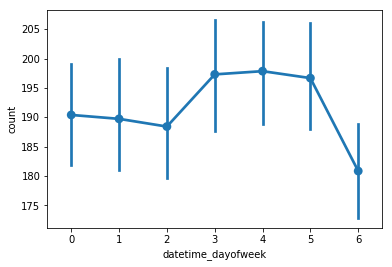

In [206]:
sns.pointplot(data=train, x="datetime_dayofweek", y="count") 

### >>> Thoughts 
- 0이 월요일, 6이 일요일. 일요일에 대여량이 적음을 알 수 있음
- 그렇다면, 시간대별 이용량을 주중 vs. 주말 or 일요일 vs. 나머지로 나누어 볼 필요가 있음

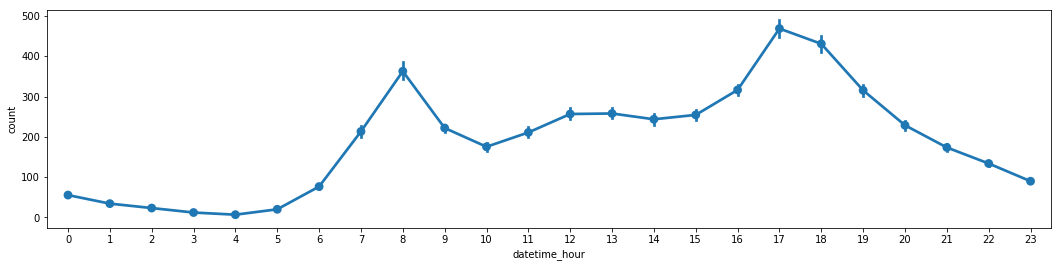

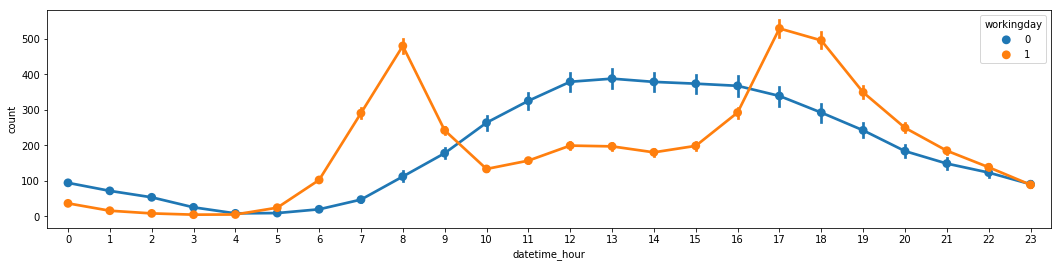

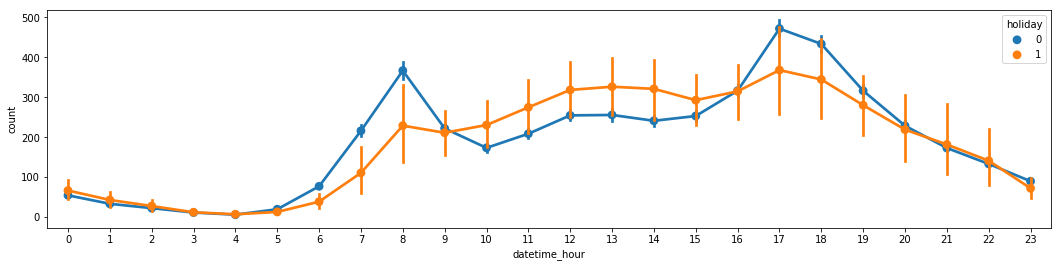

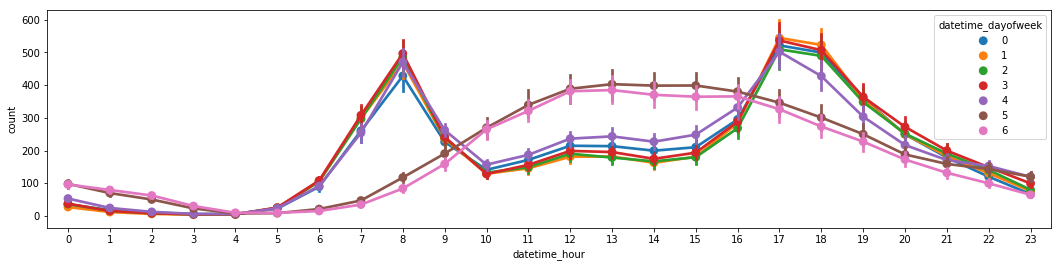

In [207]:
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.pointplot(data=train, x="datetime_hour", y="count", ax=ax1)

figure, ax2 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.pointplot(data=train, x="datetime_hour", y="count", hue="workingday", ax=ax2)

figure, ax3 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.pointplot(data=train, x="datetime_hour", y="count", hue="holiday", ax=ax3)

figure, ax4 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.pointplot(data=train, x="datetime_hour", y="count", hue="datetime_dayofweek", ax=ax4)

### >>> Thoughts
- 주말 vs. 주중에 따라 사용시간의 차이 나타남 --> 주말 변수 만들기 
- 피크타임 존재 --> 피크타임 변수 만들기 --> 주말과 주중의 피크타임 다름... 어떻게 코딩해야하는지 모르겠습니다 ㅠㅠ

In [208]:
def func_weekend(x):
    if x == 5 or x == 6:
        return 1
    else:
        return 0
train['weekend'] = train['datetime_dayofweek'].apply(func_weekend)

In [209]:
train.head(100)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,ln_count,humidity_n_temp,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_dayofweek,weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2.778819,43.253520,0,1,1,0,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,3.691376,39.537148,0,1,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,3.468856,39.537148,0,1,1,2,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2.572612,42.497194,0,1,1,3,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,0.095310,42.497194,0,1,1,4,5,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,0.095310,42.497194,0,1,1,5,5,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,0.741937,39.537148,0,1,1,6,5,1
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,1.131402,36.535177,0,1,1,7,5,1
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2.091864,42.497194,0,1,1,8,5,1
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,2.646175,56.836473,0,1,1,9,5,1


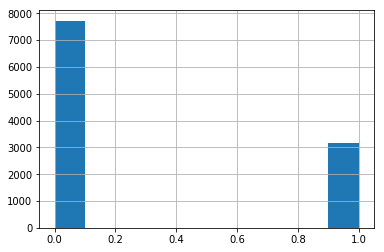

In [210]:
train['weekend'].hist()

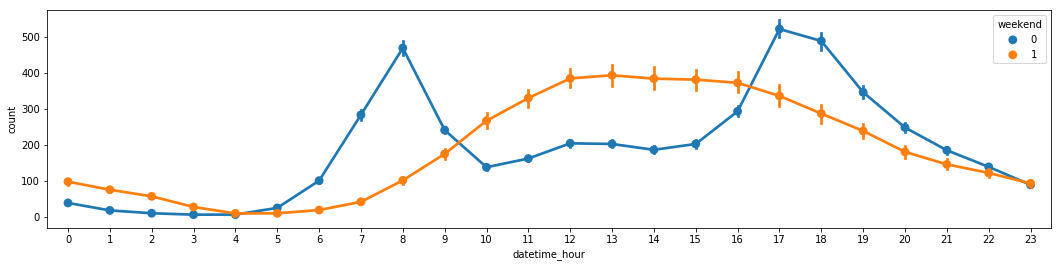

In [211]:
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.pointplot(data=train, x="datetime_hour", y="count", hue="weekend", ax = ax1)

In [212]:
train['hour_n_weekend'] = train['datetime_hour']*train['weekend']

In [213]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,ln_count,humidity_n_temp,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_dayofweek,weekend,hour_n_weekend
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,4.556957,82.050985,0.501929,6.521495,9.992559,11.541613,3.013963,0.290557,3.344938
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,1.480631,31.961689,0.500019,3.444373,5.476608,6.915838,2.004585,0.454040,6.421754
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.095310,-41.538635,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,3.740048,55.758987,0.000000,4.000000,5.000000,6.000000,1.000000,0.000000,0.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,4.977423,83.133711,1.000000,7.000000,10.000000,12.000000,3.000000,0.000000,0.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,5.649326,110.170424,1.000000,10.000000,15.000000,18.000000,5.000000,1.000000,3.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,6.884589,141.996809,1.000000,12.000000,19.000000,23.000000,6.000000,1.000000,23.000000


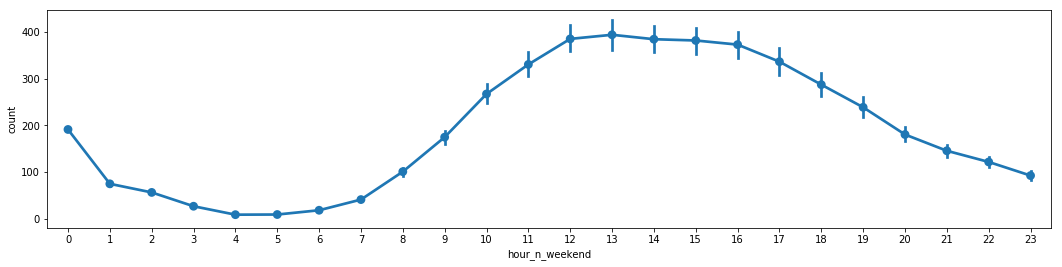

In [214]:
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.pointplot(data=train, x="hour_n_weekend", y="count", ax = ax1)

In [215]:
def func_count_grouping(x):
    if x <=42 :
        return 1
    elif x <=145:
        return 2
    elif x <=284:
        return 3
    else:
        return 4
train['count_group'] = train['count'].apply(func_count_grouping)

In [216]:
def func_ln_count_grouping(x):
    if x <=3.74 :
        return 1
    elif x <=4.98:
        return 2
    elif x <=5.65:
        return 3
    else:
        return 4
train['ln_count_group'] = train['ln_count'].apply(func_ln_count_grouping)

In [217]:
# del train["datetime_day"] 앞에서 이미 지움... 코드도 지워버려서 넣었어요

In [218]:
# del train["datetime_dayofweek"] 

In [219]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,humidity_n_temp,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_dayofweek,weekend,hour_n_weekend,count_group,ln_count_group
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,...,82.050985,0.501929,6.521495,9.992559,11.541613,3.013963,0.290557,3.344938,2.497979,2.500092
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,...,31.961689,0.500019,3.444373,5.476608,6.915838,2.004585,0.454040,6.421754,1.117590,1.115700
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,...,-41.538635,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,...,55.758987,0.000000,4.000000,5.000000,6.000000,1.000000,0.000000,0.000000,1.000000,2.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,...,83.133711,1.000000,7.000000,10.000000,12.000000,3.000000,0.000000,0.000000,2.000000,2.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,...,110.170424,1.000000,10.000000,15.000000,18.000000,5.000000,1.000000,3.000000,3.000000,3.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,...,141.996809,1.000000,12.000000,19.000000,23.000000,6.000000,1.000000,23.000000,4.000000,4.000000


### 2. Split train/test 

In [220]:
from sklearn.model_selection import train_test_split

In [221]:
df_y = train['count_group']
df_y.head()

0    1
1    1
2    1
3    1
4    1
Name: count_group, dtype: int64

In [222]:
selectedvariables = ['season','holiday','workingday','temp','atemp','humidity','windspeed',
                    'datetime_year','datetime_month','datetime_hour','weekend','hour_n_weekend','humidity_n_temp']

In [223]:
df_x = train[selectedvariables]

### 사용할 명목변수 encoding
- season, datetime_month, datetime_hour

In [224]:
season_encoded = pd.get_dummies(df_x['season'])
season_encoded.head()

,1,2,3,4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [225]:
season_encoded = season_encoded.add_suffix('season')
season_encoded.head()

,1season,2season,3season,4season
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [227]:
datetime_month_encoded = pd.get_dummies(df_x['datetime_month'])
datetime_month_encoded = datetime_month_encoded.add_suffix('month')
datetime_month_encoded.head()

,1month,2month,3month,4month,5month,6month,7month,8month,9month,10month,11month,12month
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [228]:
datetime_hour_encoded = pd.get_dummies(df_x['datetime_hour'])
datetime_hour_encoded = datetime_hour_encoded.add_suffix('hour')
datetime_hour_encoded.head()

,0hour,1hour,2hour,3hour,4hour,5hour,6hour,7hour,8hour,9hour,...,14hour,15hour,16hour,17hour,18hour,19hour,20hour,21hour,22hour,23hour
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
pd.concat([df_x, season_encoded, datetime_month_encoded, datetime_hour_encoded], axis=1).head()

,season,holiday,workingday,temp,atemp,humidity,windspeed,datetime_year,datetime_month,datetime_hour,...,14hour,15hour,16hour,17hour,18hour,19hour,20hour,21hour,22hour,23hour
0,1,0,0,9.84,14.395,81,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,9.02,13.635,80,0.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,9.02,13.635,80,0.0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,9.84,14.395,75,0.0,0,1,3,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,9.84,14.395,75,0.0,0,1,4,...,0,0,0,0,0,0,0,0,0,0


In [231]:
del df_x['season']

In [232]:
del df_x['datetime_month']

In [233]:
del df_x['datetime_hour']

In [234]:
df_x.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,datetime_year,weekend,hour_n_weekend,humidity_n_temp
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,0.501929,0.290557,3.344938,82.050985
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,0.500019,0.454040,6.421754,31.961689
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,0.000000,-41.538635
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,0.000000,0.000000,0.000000,55.758987
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,1.000000,0.000000,0.000000,83.133711
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,1.000000,1.000000,3.000000,110.170424
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,1.000000,1.000000,23.000000,141.996809


In [235]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.3, random_state =42)

## 1. 로지스틱회귀분석

In [244]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,confusion_matrix, classification_report, accuracy_score
from sklearn.cross_validation import cross_val_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [238]:
log_reg = LogisticRegression()
result = log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)

In [241]:
print('Accuracy: ' + str(accuracy_score(y_test, log_reg.predict(X_test))))
print('Test Error: ' + str(1 - accuracy_score(y_test, log_reg.predict(X_test))))

Accuracy: 0.45254133496631965
Test Error: 0.5474586650336803


In [246]:
result_log_reg_accuracy = cross_val_score(log_reg, X_train, y_train, cv=5, scoring = 'accuracy') 
print(result_log_reg_accuracy)
print(result_log_reg_accuracy.mean())
print(result_log_reg_accuracy.var())

[0.46068152 0.45347313 0.44160105 0.46320631 0.43166886]
0.450126173362617
0.00014141153183254676


## 2. LDA

In [247]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_fit = lda_model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## 3. QDA

In [248]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_model = QuadraticDiscriminantAnalysis()
qda_fit = qda_model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
